## Part 1: Building the dataframe
The webscraper collects the following data items per movie:

*   The movie's popularity ranking
*   The year the movie was released
*   The length of the movie in minutes
*   The IMDb rating of the movie
*   The movie's metascore
*   The number of votes making up the IMDb rating
*   The movie's gross earnings in US Dollars
*   The movie's genre(s)
*   The director(s) of the movie
*   The actors that play in the movie
*   The summary of the movie's plot

After collection, the data is cleaned and displayed in a panda dataframe. 

In [1]:
# Imports
import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from time import sleep
from random import randint

In [2]:
# Movie titles in English
headers = {"Accept-Language": "en-US, en;q=0.5"}

# Initialize storage variables
titles = []
years = []
time = []
imdb_ratings = []
metascores = []
votes = []
us_gross = []
genres = []
directors = []
actors = []
summaries = []

# Initialize pages and loop through each page
pages = np.arange(1, 1001, 50)


for page in pages:
    # Get the contents from each url 
    page = requests.get("https://www.imdb.com/search/title/?groups=top_1000&start=" + str(page) + "&ref_=adv_nxt", headers=headers)
  
    # Using BeautifulSoup to easily read the content
    soup = BeautifulSoup(page.text, "html.parser")
  
    sleep(randint(2,10))

    # Find all divs that contain a movie in the HTML code
    movie_div = soup.find_all('div', class_='lister-item mode-advanced')

    # Loop through each div container and grab the movie items 
    for container in movie_div:
        
        # name
        name = container.h3.a.text
        titles.append(name)
          
        # year
        year = container.h3.find('span', class_='lister-item-year').text
        years.append(year)

        # runtime
        runtime = container.p.find('span', class_='runtime').text if container.p.find('span', class_='runtime').text else np.NaN
        time.append(runtime)

        # IMDB rating
        imdb = float(container.strong.text)
        imdb_ratings.append(imdb)

        # metascore
        m_score = int(container.find('span', class_='metascore').text) if container.find('span', class_='metascore') else np.NaN
        metascores.append(m_score)

        # There are two NV containers, grab both of them as they hold both the votes and the grosses
        nv = container.find_all('span', attrs={'name': 'nv'})
     
        # filter nv for votes
        vote = nv[0].text
        votes.append(vote)
    
        # filter nv for gross returns
        grosses = nv[1].text if len(nv) > 1 else '-'
        us_gross.append(grosses)

        # genres
        genre = container.p.find('span', class_='genre').text if container.p.find('span', class_='genre').text else '-'
        genres.append(genre)

        # directors 
        directors_raw = container.find_all(text=lambda text: text and "Director" in text)
        for director in directors_raw:
            temporary_lst = []
            for i in range(len(director.find_next_siblings())):
                if director.find_next_siblings()[i].text == "|":
                    a = ', '.join(temporary_lst)
                    directors.append(a)
                    break
                else:
                    temporary_lst.append(director.find_next_siblings()[i].text)
    
        # actors
        actors_raw = container.find_all(text=lambda text: text and "Stars" in text)
        for actor in actors_raw:
            temporary_lst2 = []
            for i in range(len(actor.find_next_siblings())):
                temporary_lst2.append(actor.find_next_siblings()[i].text)  
            b = ', '.join(temporary_lst2)
            actors.append(b)
    
        # summaries
        summary = container.find('div', class_ = "ratings-bar").find_next_sibling().text if container.find('div', class_ = "ratings-bar").find_next_sibling().text else '-'
        summaries.append(summary) 

# Cleaning actors list before using it for dataframe
actors = [actor for actor in actors if actor != '']

# Building our Pandas dataframe         
movies = pd.DataFrame({
'movie': titles,
'year': years,
'timeMin': time,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes,
'us_grossMillions': us_gross,
'genre': genres,
'directors': directors,
'actors': actors,
'summaries': summaries,
})

# Adding an index
movies.index.name = 'popularity ranking'
movies.index += 1

# Cleaning data with Pandas
movies['year'] = movies['year'].str.extract('(\d+)').astype(int)
movies['timeMin'] = movies['timeMin'].str.extract('(\d+)').astype(int)
movies['votes'] = movies['votes'].str.replace(',', '').astype(int)
movies['us_grossMillions'] = movies['us_grossMillions'].map(lambda x: x.lstrip('$').rstrip('M'))
movies['us_grossMillions'] = pd.to_numeric(movies['us_grossMillions'], errors='coerce')
movies['genre'] = movies['genre'].str.strip()
movies['summaries'] = movies['summaries'].str.strip()

In [3]:
# Save data
movies.to_csv('movies.csv')

# Observe the dataframe
movies

,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
1,Tenet,2020,150,7.6,69.0,204343,53.80,"Action, Sci-Fi",Christopher Nolan,"John David Washington, Robert Pattinson, Eliza...","Armed with only one word, Tenet, and fighting ..."
2,Home Alone,1990,103,7.6,63.0,467956,285.76,"Comedy, Family",Chris Columbus,"Macaulay Culkin, Joe Pesci, Daniel Stern, John...",An eight-year-old troublemaker must protect hi...
3,Citizen Kane,1941,119,8.3,100.0,398500,1.59,"Drama, Mystery",Orson Welles,"Orson Welles, Joseph Cotten, Dorothy Comingore...",Following the death of publishing tycoon Charl...
4,Die Hard,1988,132,8.2,72.0,779370,83.01,"Action, Thriller",John McTiernan,"Bruce Willis, Alan Rickman, Bonnie Bedelia, Re...",An NYPD officer tries to save his wife and sev...
5,Klaus,2019,96,8.2,65.0,86475,NaN,"Animation, Adventure, Comedy","Sergio Pablos, Carlos Martínez López","Jason Schwartzman, J.K. Simmons, Rashida Jones...",A simple act of kindness always sparks another...
...,...,...,...,...,...,...,...,...,...,...,...
996,Airlift,2016,130,8.0,NaN,52558,NaN,"Drama, History",Raja Menon,"Akshay Kumar, Nimrat Kaur, Kumud Mishra, Praka...","When Iraq invades Kuwait in August 1990, a cal..."
997,Drishyam,2013,160,8.3,NaN,30396,NaN,"Crime, Drama, Thriller",Jeethu Joseph,"Mohanlal, Meena, Asha Sharath, Ansiba",A man goes to extreme lengths to save his fami...
998,Vizontele,2001,110,8.0,NaN,33038,NaN,"Comedy, Drama","Yilmaz Erdogan, Ömer Faruk Sorak","Yilmaz Erdogan, Demet Akbag, Altan Erkekli, Ce...",Lives of residents in a small Anatolian villag...


In [4]:
# Check the datatypes
print(movies.dtypes)

movie                object
year                  int32
timeMin               int32
imdb                float64
metascore           float64
votes                 int32
us_grossMillions    float64
genre                object
directors            object
actors               object
summaries            object
dtype: object


## Part 2: Running analyses on the data
The movies dataframe from part 1 is used to perform various analyses, to help the user select the next movie to watch. The user can access the following functions:

* Show the overall highest-ranked movies based on IMDb rating, for example, the top 3, 5, or 10 movies
* Show the highest-ranked movies within a specific genre, for example the top 3, 5, or 10 action movies
* Show all movies in which a certain actor plays, sorted by IMDb rating
* Show all movies by a certain director, sorted by their IMDb rating
* Show all movies that are shorter than x minutes, sorted by IMDb rating; for example, show all movies that are shorter than 90 minutes
* Show the movies with the most votes sorted by IMDb rating, for example the 3, 5, or 10 movies with the highest votes
* An analysis whether a higher revenue is correlated with a higher IMDb rating
* The determinants of the IMDb rating
* The share of the different genres
* The evolution of the rating over the decades


In [5]:
# Imports
import pandas as pd
import numpy as np

# For plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# For statistics
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

In [6]:
# Get the data from Part 1
movies = pd.read_csv('movies.csv').set_index('popularity ranking')

In [7]:
# Returning all movies with a certain actor sorted by imdb ranking
print ("Please enter the actor")
user_input_actor = input().lower()
movies[movies['actors'].str.lower().str.contains(user_input_actor, na = False)].sort_values('imdb', ascending = False)

Please enter the actor
Clooney


,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
402,Fantastic Mr. Fox,2009,87,7.9,83.0,196739,21.00,"Animation, Adventure, Comedy",Wes Anderson,"George Clooney, Meryl Streep, Bill Murray, Jas...",An urbane fox cannot resist returning to his f...
258,Ocean's Eleven,2001,116,7.7,74.0,512177,183.42,"Crime, Thriller",Steven Soderbergh,"George Clooney, Brad Pitt, Julia Roberts, Matt...",Danny Ocean and his ten accomplices plan to ro...
334,"O Brother, Where Art Thou?",2000,107,7.7,69.0,283138,45.51,"Adventure, Comedy, Crime","Joel Coen, Ethan Coen","George Clooney, John Turturro, Tim Blake Nelso...","In the deep south during the 1930s, three esca..."
376,Gravity,2013,91,7.7,96.0,764115,274.09,"Drama, Sci-Fi, Thriller",Alfonso Cuarón,"Sandra Bullock, George Clooney, Ed Harris, Ort...",Two astronauts work together to survive after ...


In [8]:
# Returning all movies with a certain director sorted by imdb ranking
print ("Please enter the director")
user_input_director = input().lower()
movies[movies['directors'].str.lower().str.contains(user_input_director, na = False)].sort_values('imdb', ascending = False)

Please enter the director
Spielberg


,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
78,Schindler's List,1993,195,8.9,94.0,1202643,96.90,"Biography, Drama, History",Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...","In German-occupied Poland during World War II,..."
147,Saving Private Ryan,1998,169,8.6,91.0,1223856,216.54,"Drama, War",Steven Spielberg,"Tom Hanks, Matt Damon, Tom Sizemore, Edward Burns","Following the Normandy Landings, a group of U...."
94,Raiders of the Lost Ark,1981,115,8.4,85.0,877234,248.16,"Action, Adventure",Steven Spielberg,"Harrison Ford, Karen Allen, Paul Freeman, John...","In 1936, archaeologist and adventurer Indiana ..."
146,Indiana Jones and the Last Crusade,1989,127,8.2,65.0,686897,197.17,"Action, Adventure",Steven Spielberg,"Harrison Ford, Sean Connery, Alison Doody, Den...","In 1938, after his father Professor Henry Jone..."
65,Jurassic Park,1993,127,8.1,68.0,859810,402.45,"Action, Adventure, Sci-Fi",Steven Spielberg,"Sam Neill, Laura Dern, Jeff Goldblum, Richard ...",A pragmatic paleontologist visiting an almost ...
192,Catch Me If You Can,2002,141,8.1,75.0,818718,164.62,"Biography, Crime, Drama",Steven Spielberg,"Leonardo DiCaprio, Tom Hanks, Christopher Walk...","Barely 21 yet, Frank is a skilled forger who h..."
277,Jaws,1975,124,8.0,87.0,540891,260.00,"Adventure, Thriller",Steven Spielberg,"Roy Scheider, Robert Shaw, Richard Dreyfuss, L...",When a killer shark unleashes chaos on a beach...
219,E.T. the Extra-Terrestrial,1982,115,7.8,91.0,368958,435.11,"Family, Sci-Fi",Steven Spielberg,"Henry Thomas, Drew Barrymore, Peter Coyote, De...",A troubled child summons the courage to help a...
513,The Color Purple,1985,154,7.8,78.0,77688,98.47,Drama,Steven Spielberg,"Danny Glover, Whoopi Goldberg, Oprah Winfrey, ...",A black Southern woman struggles to find her i...


In [9]:
# Returning the best movies
print ("Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10")
n = int(input())
movies.nlargest(n, columns=['imdb'])

Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10
3


,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
23,The Shawshank Redemption,1994,142,9.3,80.0,2318962,28.34,Drama,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
9,The Godfather,1972,175,9.2,100.0,1601248,134.97,"Crime, Drama",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",The aging patriarch of an organized crime dyna...
26,The Dark Knight,2008,152,9.0,84.0,2281096,534.86,"Action, Crime, Drama",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker wreaks havo...


In [10]:
# Returning the best movies within a category
print ("Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10")
x = int(input())
print ("Please enter the genre you would like to search in")
user_input_genre = input().lower()
movies[movies['genre'].str.lower().str.contains(user_input_genre, na = False)].sort_values('imdb', ascending = False).head(x)

Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10
3
Please enter the genre you would like to search in
Drama


,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
23,The Shawshank Redemption,1994,142,9.3,80.0,2318962,28.34,Drama,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
9,The Godfather,1972,175,9.2,100.0,1601248,134.97,"Crime, Drama",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",The aging patriarch of an organized crime dyna...
149,12 Angry Men,1957,96,9.0,96.0,682310,4.36,"Crime, Drama",Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",A jury holdout attempts to prevent a miscarria...


In [11]:
# Returning all movies shorter than y minutes sorted by imdb rating
print ("Please enter the maximum length of the movie in minutes")
y = int(input())
movies.loc[movies['timeMin'] <= y].sort_values('imdb', ascending = False)

Please enter the maximum length of the movie in minutes
110


,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
149,12 Angry Men,1957,96,9.0,96.0,682310,4.36,"Crime, Drama",Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",A jury holdout attempts to prevent a miscarria...
88,Whiplash,2014,106,8.5,88.0,707278,13.09,"Drama, Music",Damien Chazelle,"Miles Teller, J.K. Simmons, Melissa Benoist, P...",A promising young drummer enrolls at a cut-thr...
421,Grave of the Fireflies,1988,89,8.5,94.0,231802,NaN,"Animation, Drama, War",Isao Takahata,"Tsutomu Tatsumi, Ayano Shiraishi, Akemi Yamagu...",A young boy and his little sister struggle to ...
218,Psycho,1960,109,8.5,97.0,598973,32.00,"Horror, Mystery, Thriller",Alfred Hitchcock,"Anthony Perkins, Janet Leigh, Vera Miles, John...","A Phoenix secretary embezzles $40,000 from her..."
751,City Lights,1931,87,8.5,99.0,166094,0.02,"Comedy, Drama, Romance",Charles Chaplin,"Charles Chaplin, Virginia Cherrill, Florence L...","With the aid of a wealthy erratic tippler, a d..."
...,...,...,...,...,...,...,...,...,...,...,...
556,The Jungle Book,1967,78,7.6,65.0,164910,141.84,"Animation, Adventure, Family",Wolfgang Reitherman,"Phil Harris, Sebastian Cabot, Louis Prima, Bru...",Bagheera the Panther and Baloo the Bear have a...
554,Blood Simple,1984,99,7.6,82.0,86894,2.15,"Crime, Drama, Thriller","Joel Coen, Ethan Coen","John Getz, Frances McDormand, Dan Hedaya, M. E...",The owner of a seedy small-town Texas bar disc...
536,Snow White and the Seven Dwarfs,1937,83,7.6,95.0,180040,184.93,"Animation, Family, Fantasy","William Cottrell, David Hand, Wilfred Jackson,...","Adriana Caselotti, Harry Stockwell, Lucille La...",Exiled into the dangerous forest by her wicked...


In [12]:
# Returning the movies with the most votes
print ("Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10")
z = int(input())
movies.nlargest(z, columns=['votes'])

Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10
3


,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
23,The Shawshank Redemption,1994,142,9.3,80.0,2318962,28.34,Drama,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
26,The Dark Knight,2008,152,9.0,84.0,2281096,534.86,"Action, Crime, Drama",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker wreaks havo...
16,Inception,2010,148,8.8,74.0,2044337,292.58,"Action, Adventure, Sci-Fi",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...


In [13]:
# Returning the movies with the highest gross earnings
print ("Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10")
w = int(input())
movies.nlargest(w, columns=['us_grossMillions'])

Please enter how many movies you would like to see, e.g. if you want to see the top 10 movies, enter 10
3


,movie,year,timeMin,imdb,metascore,votes,us_grossMillions,genre,directors,actors,summaries
popularity ranking,,,,,,,,,,,
67,Star Wars: Episode VII - The Force Awakens,2015,138,7.9,80.0,854091,936.66,"Action, Adventure, Sci-Fi",J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","As a new threat to the galaxy rises, Rey, a de..."
15,Avengers: Endgame,2019,181,8.4,78.0,788229,858.37,"Action, Adventure, Drama","Anthony Russo, Joe Russo","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",After the devastating events of Avengers: Infi...
101,Avatar,2009,162,7.8,83.0,1112198,760.51,"Action, Adventure, Fantasy",James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",A paraplegic Marine dispatched to the moon Pan...


In [14]:
# Analysis whether higher revenue is correlated with a higher imdb ranking
idcs = np.bitwise_not(np.bitwise_or(np.isnan(np.array(movies.us_grossMillions)), np.isnan(np.array(movies.imdb))))
corr = pearsonr(np.array(movies.us_grossMillions[idcs]), np.array(movies.imdb[idcs]))

# correlation coefficient
print(corr[0])
# p-value of correlation
print(corr[1])

0.09310025244580497
0.0071008375622188735


In [15]:
# Determinants of the IMDB rating
reg = smf.ols('imdb ~ votes + us_grossMillions + timeMin', movies).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))

reg.summary().tables[1]

R-squared: 40.17%, N: 835


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.6009,0.035,215.277,0.000,7.532,7.670
votes,5.964e-07,2.76e-08,21.606,0.000,5.42e-07,6.51e-07
us_grossMillions,-0.0009,8.49e-05,-10.320,0.000,-0.001,-0.001
timeMin,0.0018,0.000,6.227,0.000,0.001,0.002


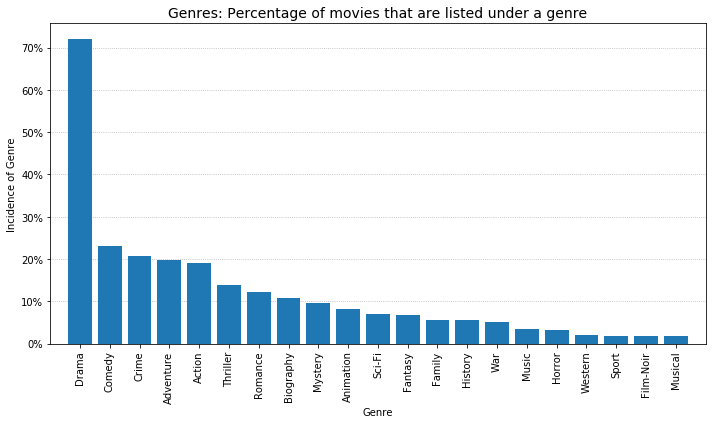

In [16]:
# Share of different genres 
def strip_list(ls):
    for i in range(0,len(ls)):
        ls[i] = ls[i].strip()
    return ls

genres = [strip_list(movies.genre[i].split(',')) for i in range(1,len(movies.genre)+1)]
sgenres = set(sum(genres, []))
n = len(genres)
dictgenres = {}
for cat in sgenres:
    counter = 0
    for el in genres:
        if cat in el:
            counter = counter +1
    dictgenres[cat]= (counter/n)

# Create list with percentage of movies which have listed the genre
dfgenres = pd.DataFrame.from_dict(dictgenres, orient='index', columns=['Percentage (in %)']).sort_values(by='Percentage (in %)', ascending=False)*100

# Plot percentage of movies which have listed the genre
n = len(dfgenres)
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.bar(range(n), dfgenres.iloc[:n,0], align="center")
ax.set_xticks(range(n))
ax.set_xticklabels(dfgenres.index[:n], rotation=90)
ax.set_xlim([-1, n])
ax.set_axisbelow(True)
ax.grid(True, axis='y', linestyle=':')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_label_text("Genre");
ax.yaxis.set_label_text("Incidence of Genre")
ax.set_title("Genres: Percentage of movies that are listed under a genre", fontsize=14)
plt.tight_layout();

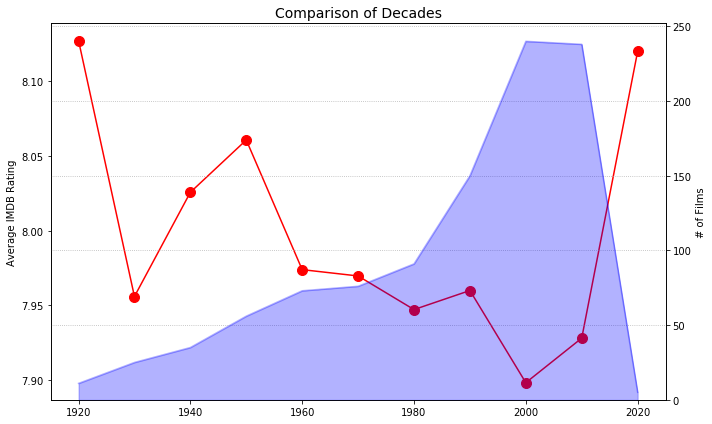

In [17]:
# Analysis of decades
movies2 = movies.copy()
movies2['decade'] = (movies2['year']/10).astype(int) * 10
decades = np.sort(movies2.decade.unique())

# Plot the average rating and the number of films for each decade
fig,ax1 = plt.subplots(1,1, figsize=(10,6))
ax2 = ax1.twinx()

movies2.groupby('decade')['imdb'].mean().plot(ax=ax1, marker='o', color='r', markersize=10)
movies2.groupby('decade').size().plot(ax=ax2, color='b', kind='area', alpha=0.3, legend=False, stacked=False)

ax1.xaxis.set_label_text("")
ax2.yaxis.set_label_text("# of Films")
ax1.yaxis.set_label_text("Average IMDB Rating")
ax1.set_title("Comparison of Decades", fontsize=14)
ax2.set_axisbelow(True)
ax2.grid(True, axis='y', linestyle=':')
plt.tight_layout();

## Part 3: HTML website
This part creates a HTML website with movie recommendations based on YOUR preferences. For your favourite actor, director and genre, the films from the movies dataframe with the highest IMDb rating are selected. Finally, these recommendations are visualized in a HTML website. The website opens automatically after running the last code cell.

Our basic website structure is saved in the *YFM.txt* file. The user's favourite actor, director and genre, but also the films with the most votes and gross returns in general are filled into the basic text file. This is then used to update the HTML website (file: *YFM.html*).

In [18]:
# Imports
import pandas as pd
import webbrowser

# Get the data from Part 1
movies = pd.read_csv('movies.csv').set_index('popularity ranking')

In [19]:
## Get user inputs and search for the corresponding movies
# actor
movies_actor = None
while movies_actor is None:
    actor_input = input("Please enter your favourite actor: ")
    movies_found = movies[movies['actors'].str.lower().str.contains(actor_input.lower(), na = False)].sort_values('imdb', ascending = False)
    if movies_found.shape[0] > 0:
        movies_actor = movies_found[:3]
    else:
        print("'{}' didn't manage to get a role in popular movies.\nPlease check your spelling or enter the name of a more successful actor.".format(actor_input))

# director
movies_director = None
while movies_director is None:
    director_input = input("Please enter your favourite director: ")
    movies_found = movies[movies['directors'].str.lower().str.contains(director_input.lower(), na = False)].sort_values('imdb', ascending = False)
    if movies_found.shape[0] > 0:
        movies_director = movies_found[:3]
    else:
        print("'{}' didn't manage to direct popular movies.\nPlease check your spelling or enter the name of a more successful director.".format(director_input))

# genre
movies_genre = None
while movies_genre is None:
    genre_input = input("Please enter your favourite genre: ")
    movies_found = movies[movies['genre'].str.lower().str.contains(genre_input.lower(), na = False)].sort_values('imdb', ascending = False)
    if movies_found.shape[0] > 0:
        movies_genre = movies_found[:3]
    else:
        print("Your favourite genre '{}' is not represented in the 1000 most popular movies on IMDB.\nPlease check your spelling or enter the another genre.".format(genre_input))

# Get the three best movies overall
movies_imdb = movies.nlargest(3, columns=['imdb'])
movies_votes = movies.nlargest(3, columns=['votes'])
movies_realmoney = movies.nlargest(3, columns=['us_grossMillions'])

Please enter your favourite actor: Clooney
Please enter your favourite director: Spielberg
Please enter your favourite genre: Drama


In [20]:
## Write the users' inputs and corresponding movies in the underlying HTML file
# Open the underlying html file (in .txt format)
txt = open('YFM.txt', 'rt')

# Read file contents to string
data = txt.read()

## Replace all occurrences of the required strings
# actor
data = data.replace('act1', actor_input)
data = data.replace('YOUR ACTOR', actor_input.upper())
data = data.replace('Bestmov', movies_actor.iloc[0,0])
if len(movies_actor) > 1:
    data = data.replace('Bestmov2', movies_actor.iloc[1,0])
    if len(movies_actor) > 2:
        data = data.replace('Bestmov3', movies_actor.iloc[2,0])        
    else:
        data = data.replace('Bestmov3', '{} only appears in two top 1000 IMDB films...'.format(actor_input.upper()))
else:
    data.replace('Bestmov2', "{} didn't manage to get a role in more than one popular film".format(actor_input.upper()))
    data.replace('Bestmov3', '...')
    
# director
data = data.replace('movdir1', movies_director.iloc[0,0])
if len(movies_director) > 1:
    data = data.replace('movdir2', movies_director.iloc[1,0])
    if len(movies_actor) > 2:
        data = data.replace('movdir3', movies_director.iloc[2,0])
    else:
        data = data.replace('movdir3', '{} only directs two top 1000 IMDB films...'.format(director_input.upper()))
else:
    data.replace('movdir2', "{} didn't manage to direct more than one popular film...".format(director_input.upper()))
    data.replace('movdir3', '...')   

# genre
data = data.replace('favcat', movies_genre.iloc[0,0])

# votes
data = data.replace('most.votes', movies_votes.iloc[0,0])
data = data.replace('most.votes2', movies_votes.iloc[1,0])
data = data.replace('most.votes3', movies_votes.iloc[2,0])

# realmoney
data = data.replace('realmoney1', movies_votes.iloc[0,0])
data = data.replace('realmoney2', movies_votes.iloc[1,0])
data = data.replace('realmoney3', movies_votes.iloc[2,0])

## Close the input file
txt.close()

In [21]:
# Update the HTML and create the website
# Open the output file in write mode
index = open(r"YFM.html", "wt")

# Overrite the input file with the resulting data
index.write(data)

# Close the file
index.close()

# Open HTML file in the webbrowser
webbrowser.open("YFM.html")

True